In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import shapiro
import warnings
import math
from math import sqrt
import statsmodels.api as sm
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go

warnings.filterwarnings("ignore", "use_inf_as_na option is deprecated")

# Desativar o aviso relacionado a use_inf_as_na
pd.set_option('mode.use_inf_as_na', True)

df = pd.read_csv("/kaggle/input/united-states-flood-database/USFD_v1.1.csv")

df.head()

/tmp/ipykernel_18/1234462543.py:29: DtypeWarning: Columns (1,2,8,13,14,16,17,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/united-states-flood-database/USFD_v1.1.csv")


,ID,DATE_BEGIN,DATE_END,DURATION,LON,LAT,COUNTRY,STATE,LOCATION,AREA,...,SOURCE_ID,DESCRIPTION,slope,dem,LULC,DISTANT_RIVER,CONT_AREA,DEPTH,year,geometry
0,0,199610211400,199610211400,0.0,-96.350956,35.846673,United States of America,OKLAHOMA,BRYAN,NaN,...,5570362,Flash flood waters washed out a small bridge a...,0.981851,250.0,126.0,0.449685,0.056706,NaN,1996.0,NaN
1,1,199601241700,199601241700,0.0,-86.728891,39.020047,United States of America,INDIANA,FAYETTE,NaN,...,5536059,"On the 23rd, many areas received around an inc...",1.232995,251.0,30.0,11.573957,1.323704,NaN,1996.0,NaN
2,2,199601221200,199601311659,9.0,-85.759407,38.254238,United States of America,KENTUCKY,HARDIN,NaN,...,5549485,Snowmelt and heavy rain caused widespread floo...,3.993053,145.0,50.0,0.902991,0.049660,NaN,1996.0,NaN
3,3,199601270430,199601271130,0.0,-82.568268,35.577000,United States of America,NORTH CAROLINA,HENDERSON,NaN,...,5537263,Prolonged rain became heavier following the ic...,18.991732,615.0,126.0,0.000000,113.593987,NaN,1996.0,NaN
4,4,199601191330,199601201200,0.0,NaN,NaN,United States of America,NEW YORK,BROOME,NaN,...,5583210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996.0,NaN


In [2]:
df['DATE_BEGIN'].describe()

count     6.985060e+05
unique    1.987640e+05
top       2.019060e+11
freq      2.320000e+02
Name: DATE_BEGIN, dtype: float64

In [3]:
df['DATE_END'].describe()

count           693352
unique          196576
top       201105010459
freq               232
Name: DATE_END, dtype: object

In [4]:


# Converter 'DATE_BEGIN' para datetime com errors='coerce'
df['DATE_BEGIN'] = pd.to_datetime(df['DATE_BEGIN'], format='%Y%m%d%H%M', errors='coerce')

# Converter 'DATE_END' para datetime com errors='coerce'
df['DATE_END'] = pd.to_datetime(df['DATE_END'], format='%Y%m%d%H%M', errors='coerce')

# Verificar as alterações
print(df['DATE_BEGIN'].describe())
print(df['DATE_END'].describe())


count                            98292
mean     2005-10-06 15:32:34.950555648
min                1996-01-02 04:00:00
25%                2001-09-05 22:22:30
50%                2005-12-12 03:52:30
75%                2010-05-13 10:42:00
max                2014-12-28 08:00:00
Name: DATE_BEGIN, dtype: object
count                           144360
mean     2009-07-28 01:52:19.344971008
min                1980-01-01 02:04:00
25%                2003-10-18 23:00:00
50%                2010-01-26 00:22:30
75%                2015-11-19 09:45:00
max                2020-08-01 07:59:00
Name: DATE_END, dtype: object


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698507 entries, 0 to 698506
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ID             698507 non-null  int64         
 1   DATE_BEGIN     98292 non-null   datetime64[ns]
 2   DATE_END       144360 non-null  datetime64[ns]
 3   DURATION       693532 non-null  float64       
 4   LON            672424 non-null  float64       
 5   LAT            672423 non-null  float64       
 6   COUNTRY        698507 non-null  object        
 7   STATE          698110 non-null  object        
 8   LOCATION       144579 non-null  object        
 9   AREA           94907 non-null   float64       
 10  FATALITY       14078 non-null   float64       
 11  DAMAGE         144462 non-null  float64       
 12  SEVERITY       695 non-null     float64       
 13  SOURCE         131241 non-null  object        
 14  CAUSE          89692 non-null   object        
 15  

In [6]:
df.head()

,ID,DATE_BEGIN,DATE_END,DURATION,LON,LAT,COUNTRY,STATE,LOCATION,AREA,...,SOURCE_ID,DESCRIPTION,slope,dem,LULC,DISTANT_RIVER,CONT_AREA,DEPTH,year,geometry
0,0,1996-10-21 14:00:00,1996-10-21 14:00:00,0.0,-96.350956,35.846673,United States of America,OKLAHOMA,BRYAN,NaN,...,5570362,Flash flood waters washed out a small bridge a...,0.981851,250.0,126.0,0.449685,0.056706,NaN,1996.0,NaN
1,1,1996-01-24 17:00:00,1996-01-24 17:00:00,0.0,-86.728891,39.020047,United States of America,INDIANA,FAYETTE,NaN,...,5536059,"On the 23rd, many areas received around an inc...",1.232995,251.0,30.0,11.573957,1.323704,NaN,1996.0,NaN
2,2,1996-01-22 12:00:00,1996-01-31 16:59:00,9.0,-85.759407,38.254238,United States of America,KENTUCKY,HARDIN,NaN,...,5549485,Snowmelt and heavy rain caused widespread floo...,3.993053,145.0,50.0,0.902991,0.049660,NaN,1996.0,NaN
3,3,1996-01-27 04:30:00,1996-01-27 11:30:00,0.0,-82.568268,35.577000,United States of America,NORTH CAROLINA,HENDERSON,NaN,...,5537263,Prolonged rain became heavier following the ic...,18.991732,615.0,126.0,0.000000,113.593987,NaN,1996.0,NaN
4,4,1996-01-19 13:30:00,1996-01-20 12:00:00,0.0,NaN,NaN,United States of America,NEW YORK,BROOME,NaN,...,5583210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996.0,NaN


In [7]:
df.isnull().sum()

ID                    0
DATE_BEGIN       600215
DATE_END         554147
DURATION           4975
LON               26083
LAT               26084
COUNTRY               0
STATE               397
LOCATION         553928
AREA             603600
FATALITY         684429
DAMAGE           554045
SEVERITY         697812
SOURCE           567266
CAUSE            608815
SOURCE_DB             0
SOURCE_ID          4927
DESCRIPTION      571959
slope             26661
dem               27051
LULC              26185
DISTANT_RIVER     26131
CONT_AREA        172776
DEPTH            632051
year             541964
geometry         156415
dtype: int64

In [8]:
import missingno as msno

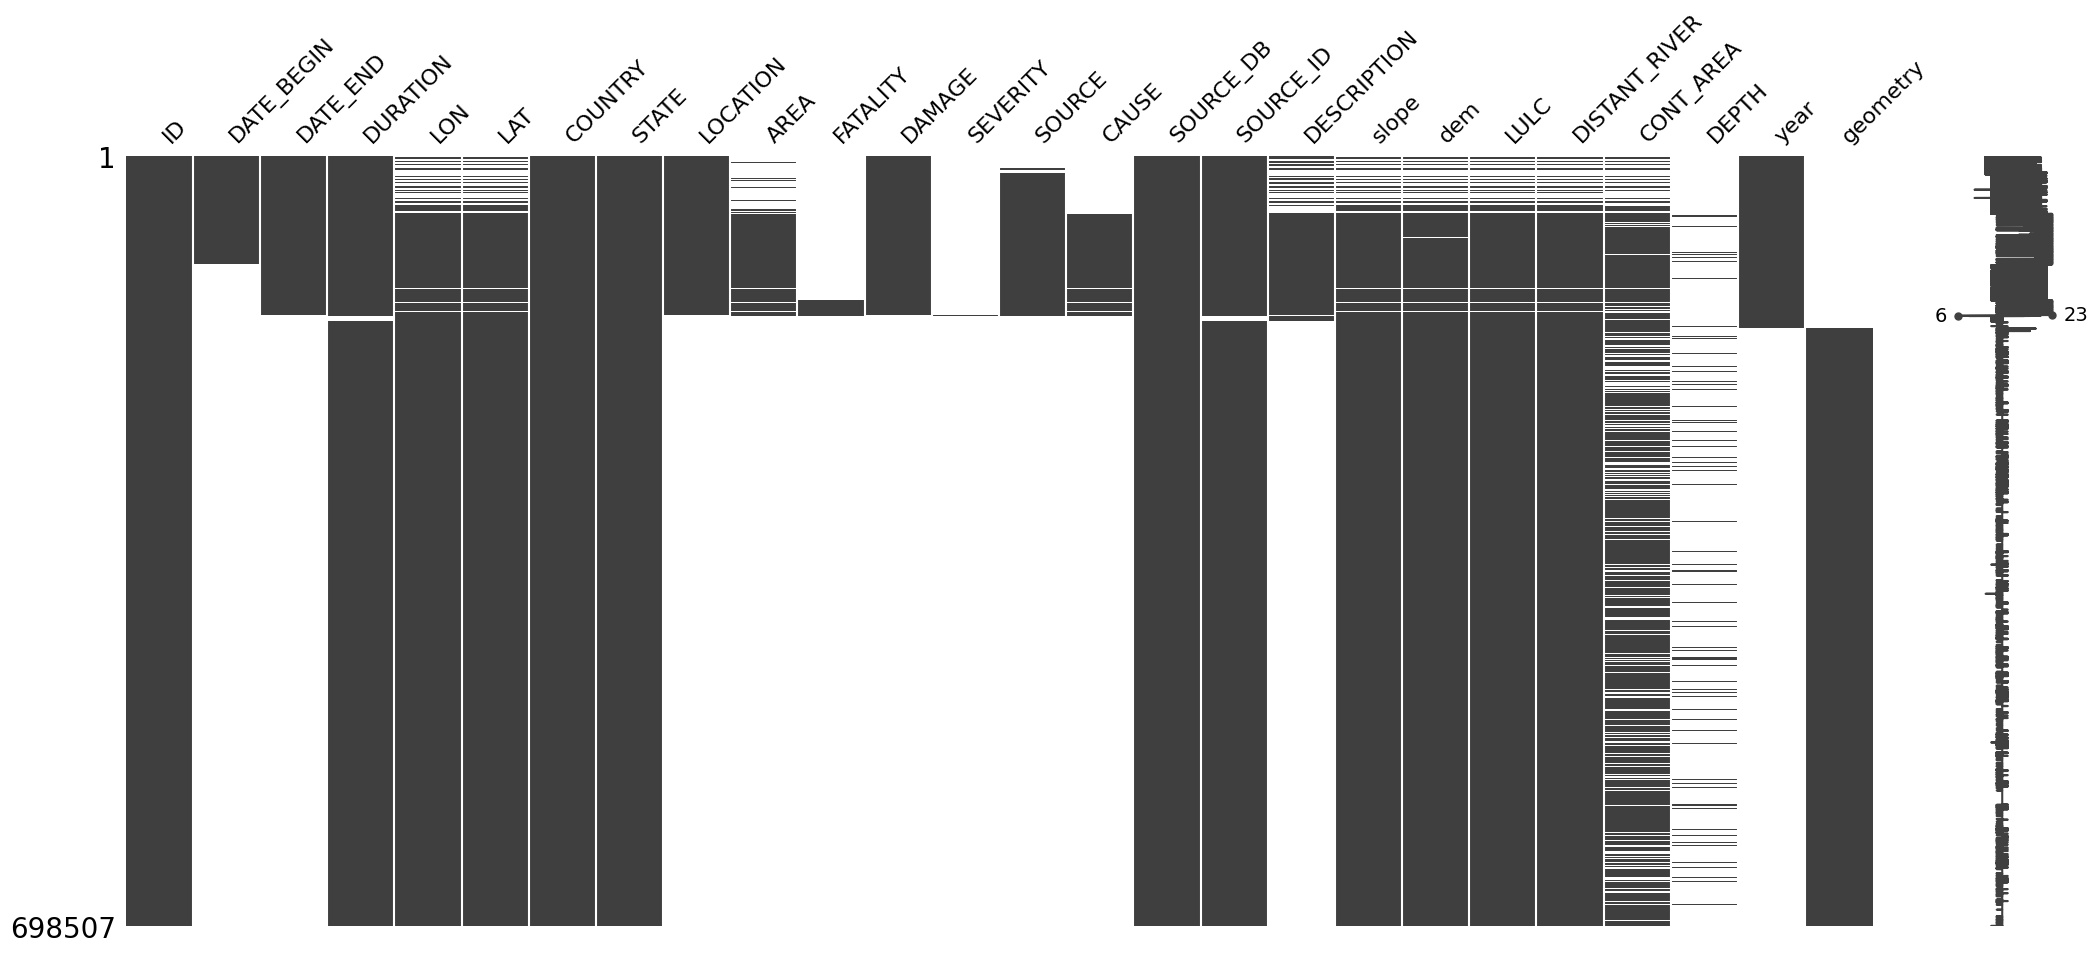

<Figure size 1500x900 with 0 Axes>

In [9]:
msno.matrix(df)
plt.figure(figsize = (15,9))
plt.show()

<Axes: >

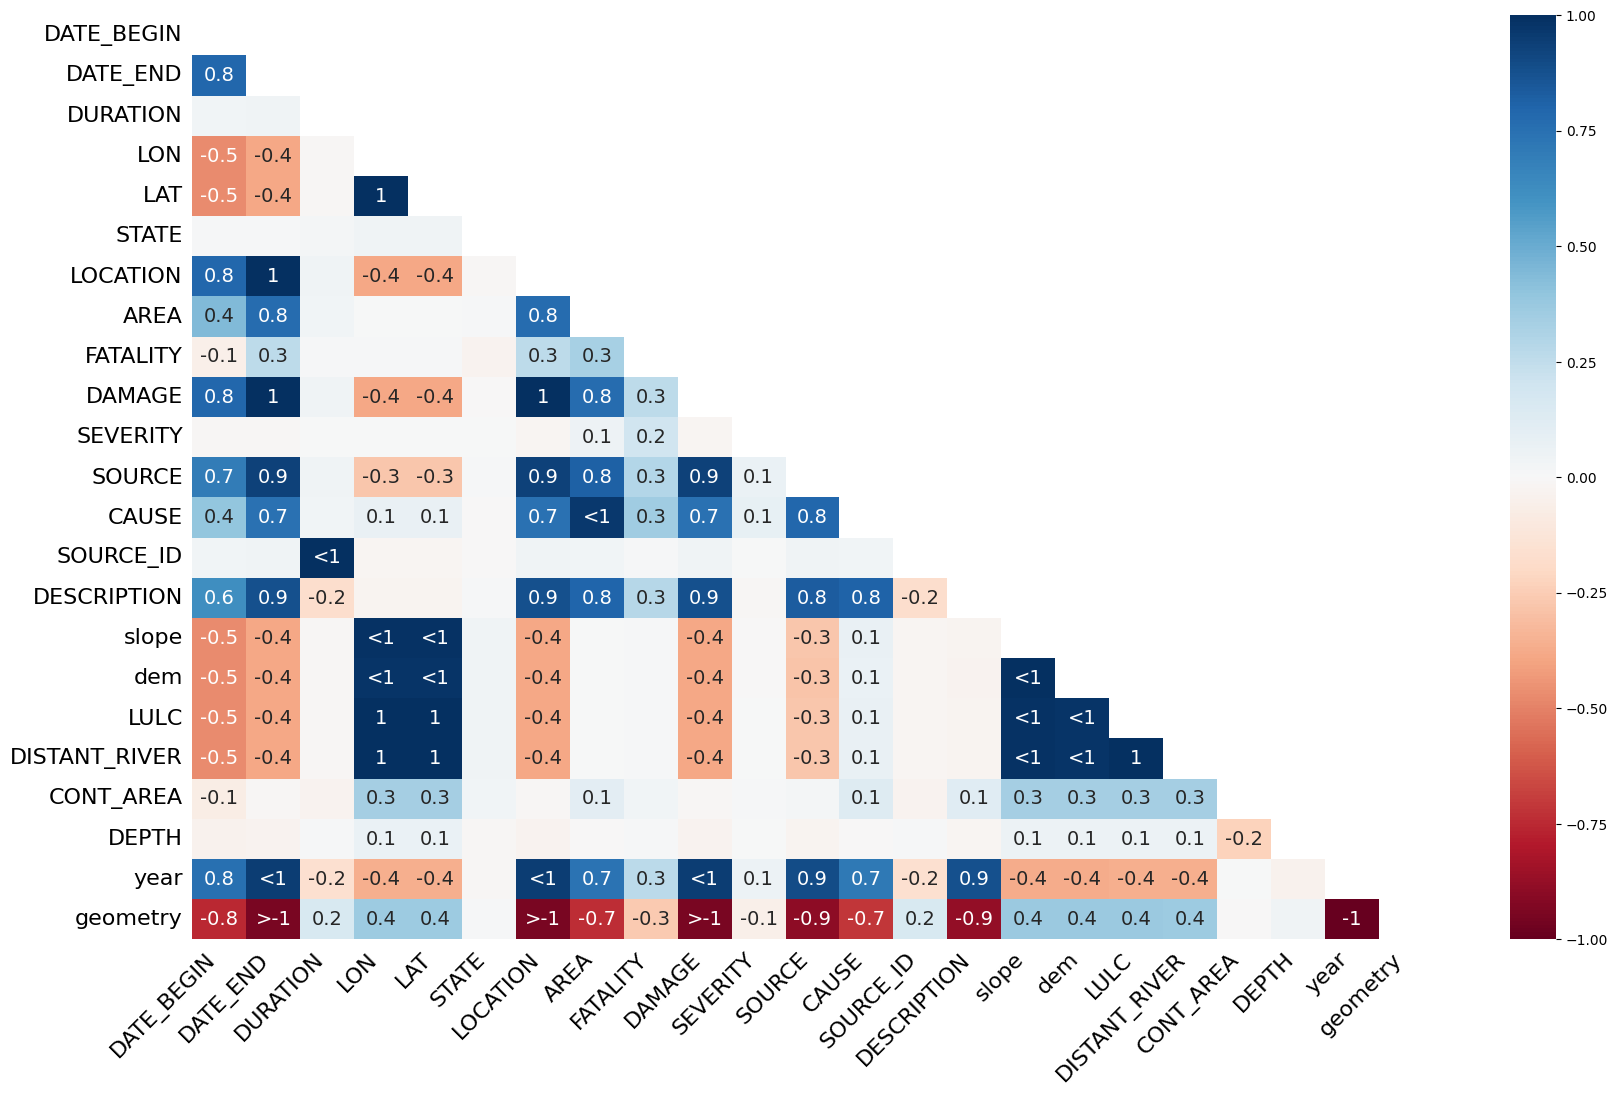

In [10]:
msno.heatmap(df, labels = True)

In [11]:

missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
missing_columns

['DATE_BEGIN',
 'DATE_END',
 'DURATION',
 'LON',
 'LAT',
 'STATE',
 'LOCATION',
 'AREA',
 'FATALITY',
 'DAMAGE',
 'SEVERITY',
 'SOURCE',
 'CAUSE',
 'SOURCE_ID',
 'DESCRIPTION',
 'slope',
 'dem',
 'LULC',
 'DISTANT_RIVER',
 'CONT_AREA',
 'DEPTH',
 'year',
 'geometry']

<Axes: >

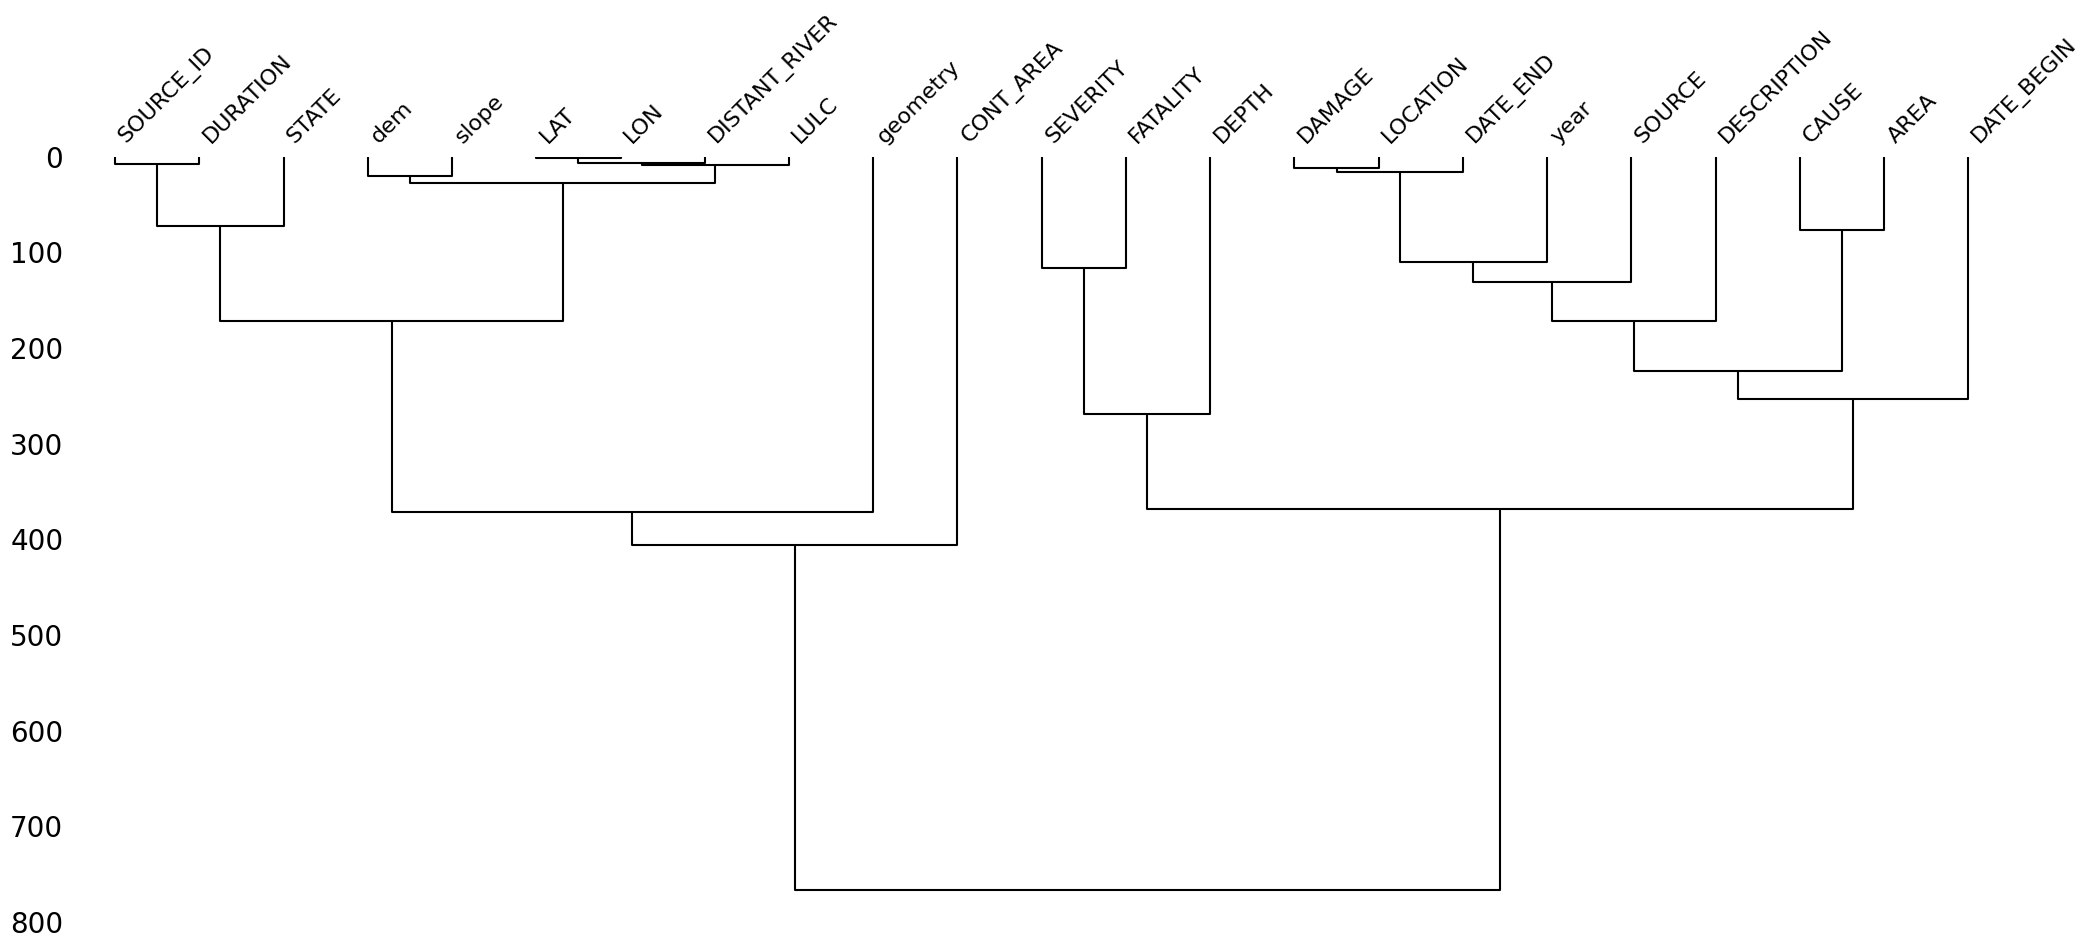

In [12]:
msno.dendrogram(df[missing_columns])

In [13]:
def get_numerical_summary(df):
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    return missing_percent

In [14]:
missing_percent = get_numerical_summary(df)

DATE_BEGIN : 600215 (85.928%)
DATE_END : 554147 (79.333%)
DURATION : 4975 (0.712%)
LON : 26083 (3.734%)
LAT : 26084 (3.734%)
STATE : 397 (0.057%)
LOCATION : 553928 (79.302%)
AREA : 603600 (86.413%)
FATALITY : 684429 (97.985%)
DAMAGE : 554045 (79.318%)
SEVERITY : 697812 (99.901%)
SOURCE : 567266 (81.211%)
CAUSE : 608815 (87.159%)
SOURCE_ID : 4927 (0.705%)
DESCRIPTION : 571959 (81.883%)
slope : 26661 (3.817%)
dem : 27051 (3.873%)
LULC : 26185 (3.749%)
DISTANT_RIVER : 26131 (3.741%)
CONT_AREA : 172776 (24.735%)
DEPTH : 632051 (90.486%)
year : 541964 (77.589%)
geometry : 156415 (22.393%)


In [15]:
df_temp = df.copy()

In [16]:
# Threshold to remove attribute having missing values greater than threshold
ATTRIBUTE_THRESHOLD = 25 #25% in this case 

for col, per in missing_percent.items():
    if per > ATTRIBUTE_THRESHOLD:
        df_temp.drop(col, axis = 1, inplace = True)

In [17]:
_ = get_numerical_summary(df_temp)

DURATION : 4975 (0.712%)
LON : 26083 (3.734%)
LAT : 26084 (3.734%)
STATE : 397 (0.057%)
SOURCE_ID : 4927 (0.705%)
slope : 26661 (3.817%)
dem : 27051 (3.873%)
LULC : 26185 (3.749%)
DISTANT_RIVER : 26131 (3.741%)
CONT_AREA : 172776 (24.735%)
geometry : 156415 (22.393%)


In [18]:
del df_temp

In [19]:
df_temp = df.copy()

In [20]:
# Getting Missing count of each sample            

df_temp['missing_count'] = df_temp.isnull().sum(axis=1)

In [21]:
# Threshold to remove samples having missing values greater than threshold
SAMPLE_THRESHOLD = 5

print("Samples Before Removal : {}".format(df_temp.shape[0]))

df_temp.drop(df_temp[df_temp['missing_count'] > SAMPLE_THRESHOLD].index, axis = 0, inplace = True)

print("Samples After Removal : {}".format(df_temp.shape[0]))

Samples Before Removal : 698507
Samples After Removal : 88611


In [22]:
del df_temp

In [23]:
cat_missing_cols = [col for col in missing_columns if df[col].dtype == 'object']
cat_missing_cols

['STATE',
 'LOCATION',
 'SOURCE',
 'CAUSE',
 'SOURCE_ID',
 'DESCRIPTION',
 'geometry']

In [24]:
df.STATE.value_counts()

STATE
NORTH CAROLINA          42448
TEXAS                   34872
MISSOURI                34826
PENNSYLVANIA            34440
NEW YORK                31240
GEORGIA                 28280
VIRGINIA                27349
KENTUCKY                26287
MARYLAND                24935
OHIO                    24787
ILLINOIS                22169
INDIANA                 20582
CALIFORNIA              19427
NEW JERSEY              19320
TENNESSEE               17326
WASHINGTON              16681
KANSAS                  15116
OKLAHOMA                15090
WISCONSIN               14459
IOWA                    14403
MISSISSIPPI             12859
ARKANSAS                12846
WEST VIRGINIA           12582
MICHIGAN                12443
COLORADO                11574
OREGON                  11437
FLORIDA                 11244
SOUTH CAROLINA          10658
ALABAMA                 10628
MASSACHUSETTS           10249
ARIZONA                  8775
CONNECTICUT              7953
NEBRASKA                 7139
VERM

In [25]:
df[cat_missing_cols] = df[cat_missing_cols].fillna('Missing')
df.STATE.value_counts()

STATE
NORTH CAROLINA          42448
TEXAS                   34872
MISSOURI                34826
PENNSYLVANIA            34440
NEW YORK                31240
GEORGIA                 28280
VIRGINIA                27349
KENTUCKY                26287
MARYLAND                24935
OHIO                    24787
ILLINOIS                22169
INDIANA                 20582
CALIFORNIA              19427
NEW JERSEY              19320
TENNESSEE               17326
WASHINGTON              16681
KANSAS                  15116
OKLAHOMA                15090
WISCONSIN               14459
IOWA                    14403
MISSISSIPPI             12859
ARKANSAS                12846
WEST VIRGINIA           12582
MICHIGAN                12443
COLORADO                11574
OREGON                  11437
FLORIDA                 11244
SOUTH CAROLINA          10658
ALABAMA                 10628
MASSACHUSETTS           10249
ARIZONA                  8775
CONNECTICUT              7953
NEBRASKA                 7139
VERM

In [26]:
df[cat_missing_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698507 entries, 0 to 698506
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   STATE        698507 non-null  object
 1   LOCATION     698507 non-null  object
 2   SOURCE       698507 non-null  object
 3   CAUSE        698507 non-null  object
 4   SOURCE_ID    698507 non-null  object
 5   DESCRIPTION  698507 non-null  object
 6   geometry     698507 non-null  object
dtypes: object(7)
memory usage: 37.3+ MB


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698507 entries, 0 to 698506
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ID             698507 non-null  int64         
 1   DATE_BEGIN     98292 non-null   datetime64[ns]
 2   DATE_END       144360 non-null  datetime64[ns]
 3   DURATION       693532 non-null  float64       
 4   LON            672424 non-null  float64       
 5   LAT            672423 non-null  float64       
 6   COUNTRY        698507 non-null  object        
 7   STATE          698507 non-null  object        
 8   LOCATION       698507 non-null  object        
 9   AREA           94907 non-null   float64       
 10  FATALITY       14078 non-null   float64       
 11  DAMAGE         144462 non-null  float64       
 12  SEVERITY       695 non-null     float64       
 13  SOURCE         698507 non-null  object        
 14  CAUSE          698507 non-null  object        
 15  

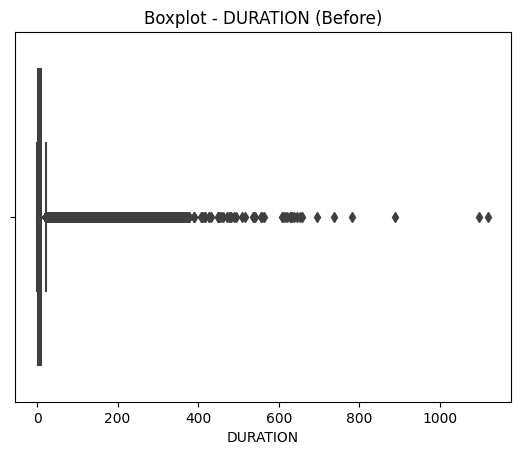

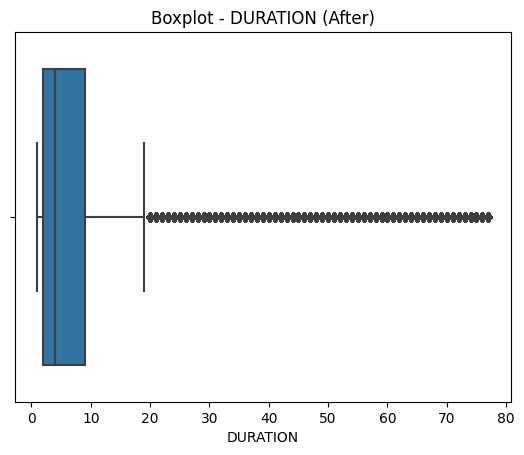

/tmp/ipykernel_18/203595385.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary = pd.concat([summary, pd.DataFrame(summary_row, index=[0])], ignore_index=True)


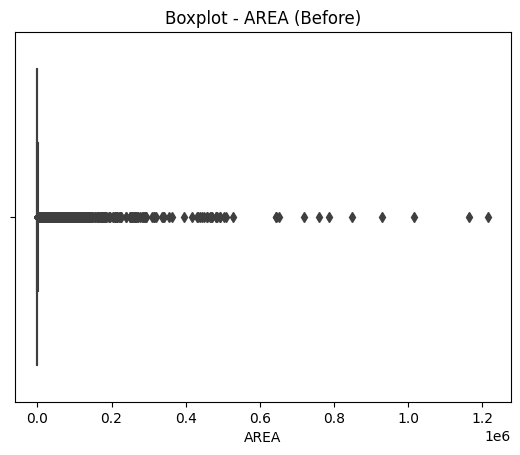

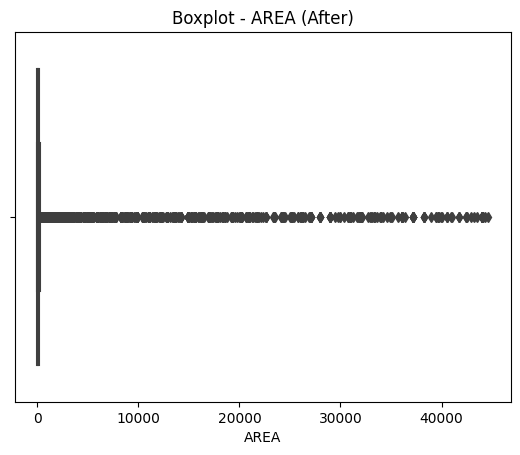

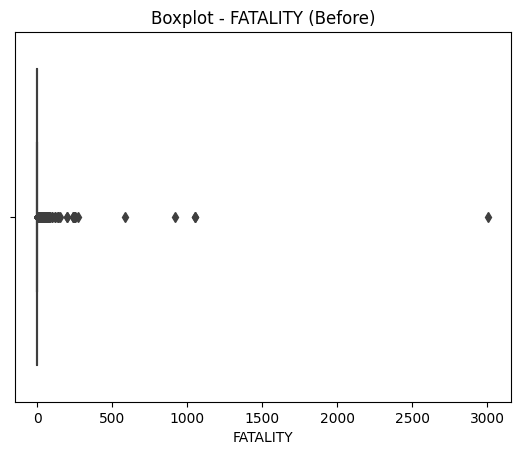

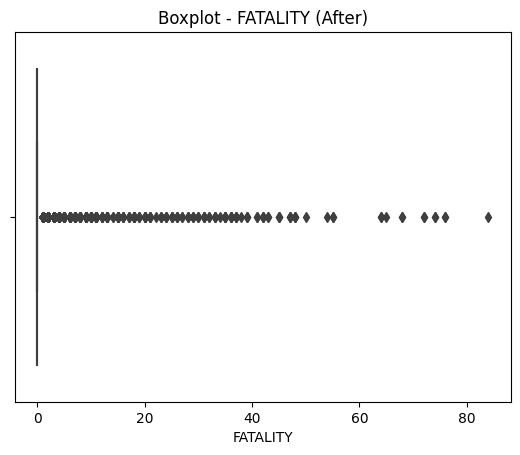

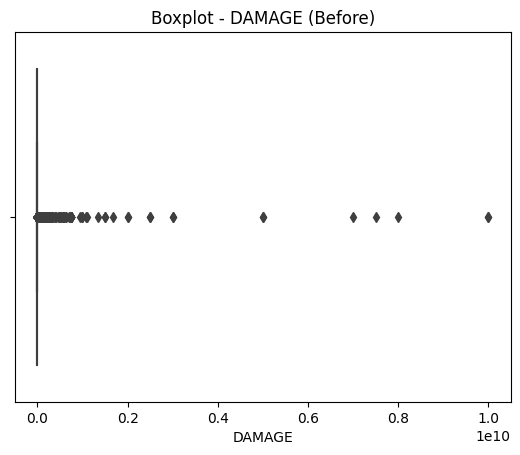

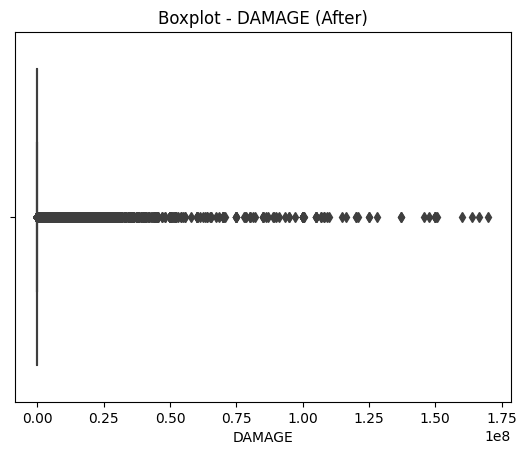

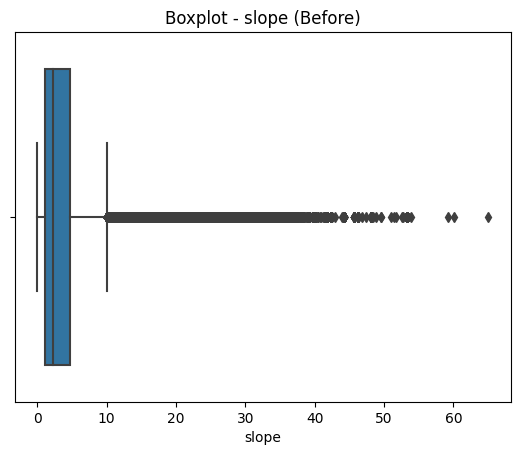

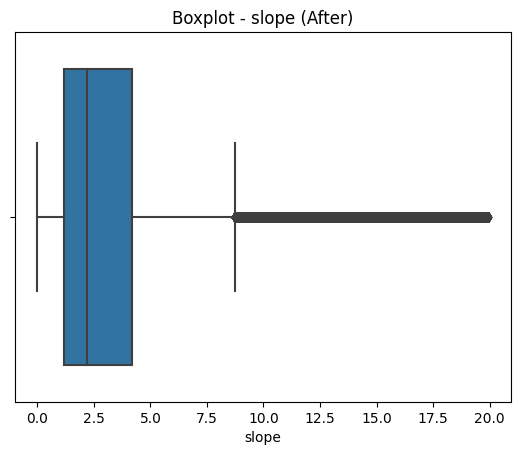

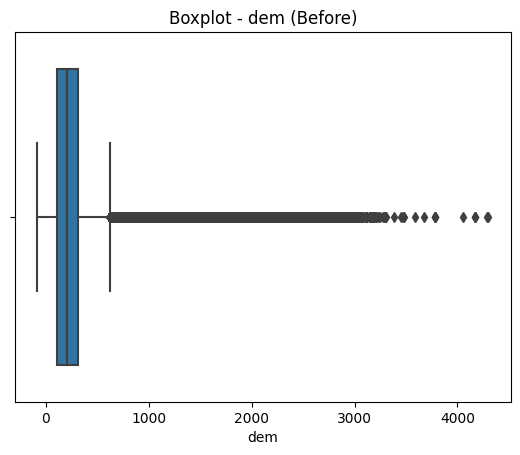

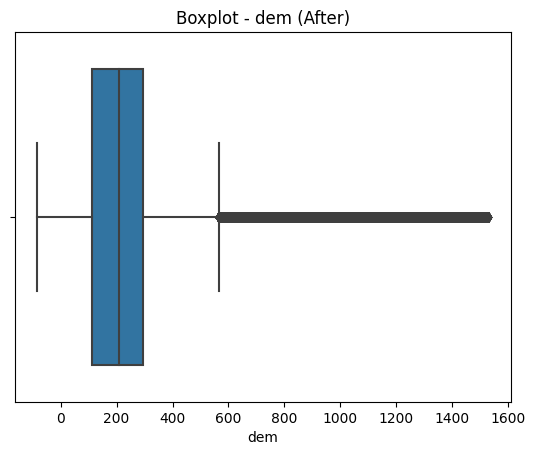

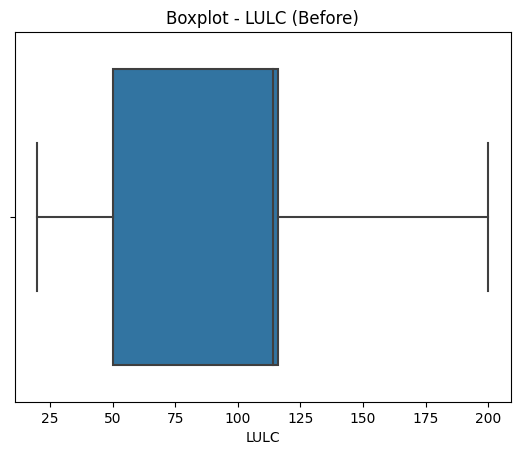

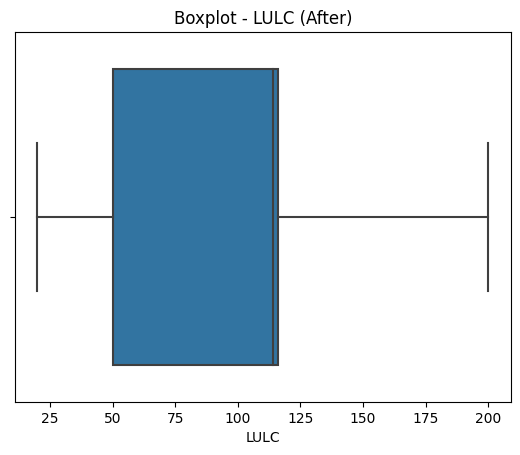

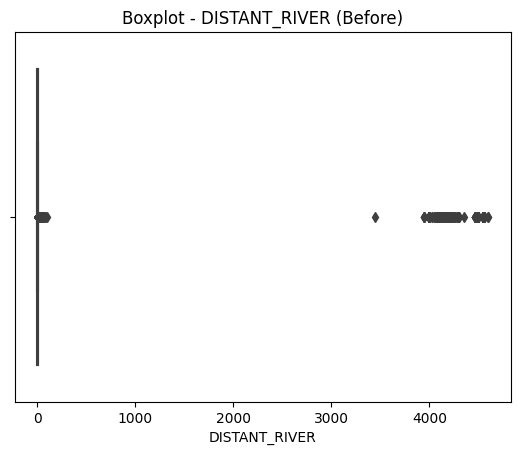

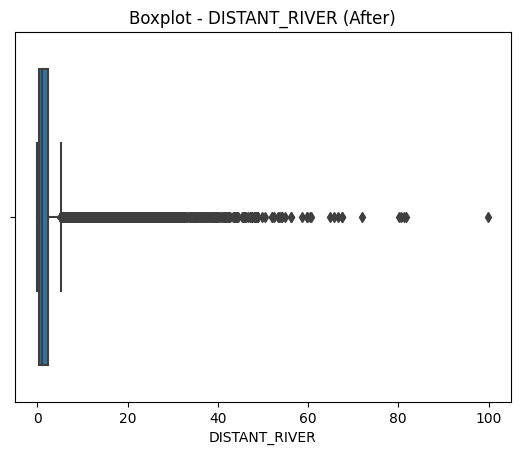

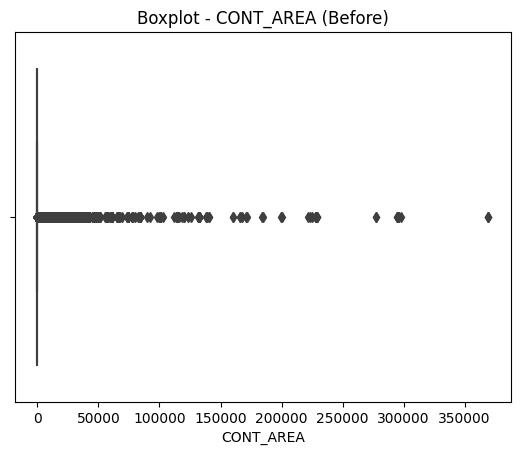

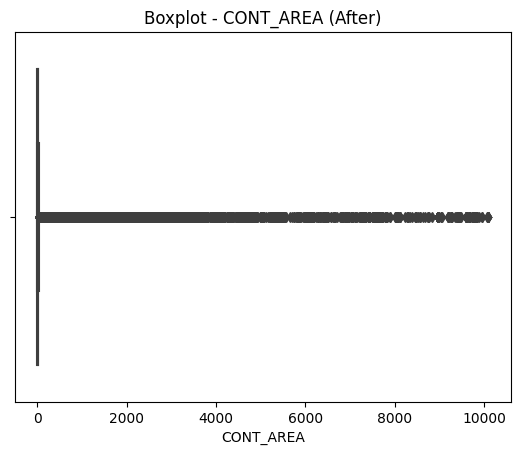

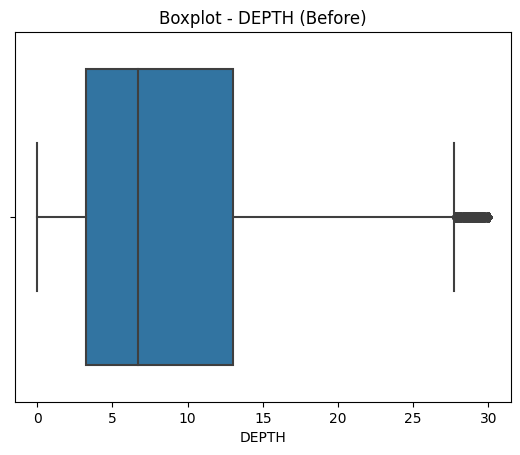

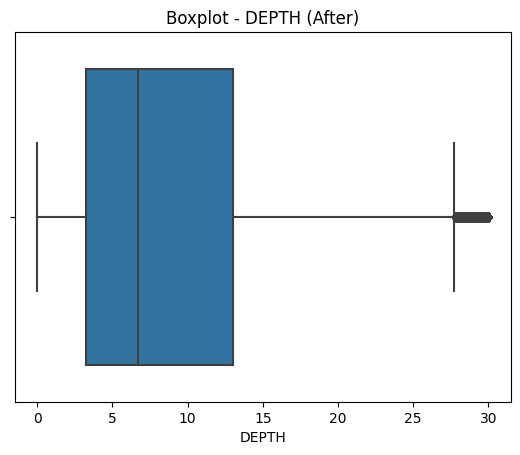

          Column  Min_before  Median_before   Mean_before    Max_before  \
0       DURATION    1.000000       4.000000  1.103910e+01  1.120000e+03   
1           AREA    8.042477      32.169909  9.185739e+02  1.216616e+06   
2       FATALITY    0.000000       0.000000  1.161244e+00  3.006000e+03   
3         DAMAGE    0.000000       0.000000  1.106862e+06  1.000010e+10   
4          slope    0.000000       2.193040  4.118608e+00  6.503558e+01   
5            dem  -83.000000     208.000000  3.157501e+02  4.301000e+03   
6           LULC   20.000000     114.000000  8.731482e+01  2.000000e+02   
7  DISTANT_RIVER    0.000000       1.060791  2.954255e+00  4.601344e+03   
8      CONT_AREA    0.004820       3.717239  1.880747e+02  3.693690e+05   
9          DEPTH    0.010000       6.690000  9.389885e+00  3.000000e+01   

   Min_after  Median_after     Mean_after     Max_after  
0   1.000000      4.000000       8.385238  7.700000e+01  
1   8.042477     32.169909     303.792779  4.462703e+04  


In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Supondo que df é o seu DataFrame

# Seleciona apenas as colunas do tipo float64, exceto 'LAT', 'LON' e 'FATALITY'
float_columns = df.select_dtypes(include=['float64']).drop(columns=['LAT', 'LON', 'year', 'SEVERITY'])

# Cria um DataFrame vazio para armazenar os resultados
summary = pd.DataFrame(columns=['Column', 'Min_before', 'Median_before', 'Mean_before', 'Max_before', 'Min_after', 'Median_after', 'Mean_after', 'Max_after'])

# Itera sobre as colunas selecionadas
for column in float_columns:
    # Substitui os valores zeros por NaN
    if column in ['DURATION', 'AREA','DEPTH']:
        df[column] = df[column].replace(0, np.nan)

    # Calcula os valores antes de limpar os outliers
    min_before = df[column].min()
    median_before = df[column].median()  # Calcula a mediana
    mean_before = df[column].mean()
    max_before = df[column].max()

    # Exibe o boxplot antes de substituir os outliers
    sns.boxplot(x=column, data=df)
    plt.title(f'Boxplot - {column} (Before)')
    plt.show()

    # Calcula o Z-score para os valores na coluna atual
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())

    # Define um limite para identificar outliers
    z_score_limit = 3

    # Substitui os valores que têm um Z-score maior que o limite pelo valor da mediana
    df.loc[z_scores > z_score_limit, column] = median_before

    # Calcula os valores após substituir os outliers
    min_after = df[column].min()
    median_after = df[column].median()  # Calcula a mediana
    mean_after = df[column].mean()
    max_after = df[column].max()

    # Exibe o boxplot após substituir os outliers
    sns.boxplot(x=column, data=df)
    plt.title(f'Boxplot - {column} (After)')
    plt.show()

    # Adiciona os resultados ao DataFrame summary
    summary_row = {'Column': column, 
                   'Min_before': min_before, 'Median_before': median_before, 'Mean_before': mean_before, 'Max_before': max_before,
                   'Min_after': min_after, 'Median_after': median_after, 'Mean_after': mean_after, 'Max_after': max_after}
    summary = pd.concat([summary, pd.DataFrame(summary_row, index=[0])], ignore_index=True)

# Exibe o resumo completo
print(summary)


